In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten ,Dropout
import tensorflow as tf
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score, roc_curve, auc ,accuracy_score,precision_score,recall_score,f1_score,accuracy_score

In [22]:
image_size = 32
num_channels = 3
num_features = image_size * image_size * num_channels
num_classes = 10

num_train = 49000

In [23]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

Train data shape: (50000, 32, 32, 3)
Test  data shape: (10000, 32, 32, 3)


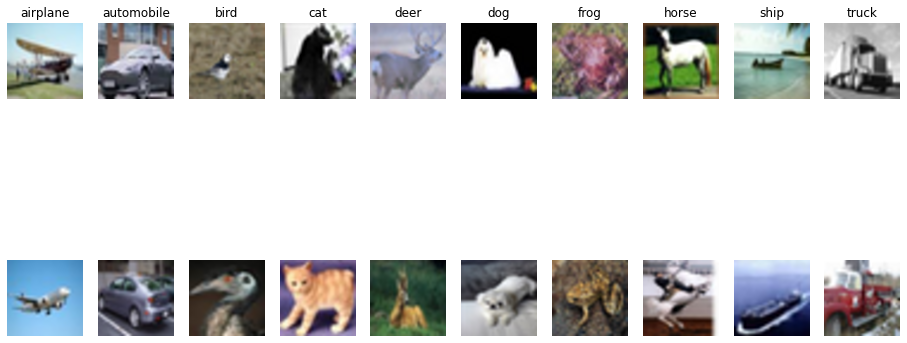

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 2

plt.figure(figsize=(16, 8))

for cls, name in enumerate(class_names):
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(samples_per_class, num_classes, i * num_classes + cls + 1)
        plt.imshow(X_train[idx], interpolation='spline16')
        plt.axis('off')
        if i == 0:
            plt.title(class_names[cls])

In [5]:
# convert pixel range from [0, 255] to [0., 1.]
#X_test = datagen.standardize(X_test)
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# rescale all image values to lie in 0-1
X_train /= 255.0
# 0 is batch dimension, that is, the whole dataset, 1, and 2 are width and height of the images
# we are basically saying, calculate the mean/std, all the images (withxheight) in the whole dataset
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
X_train = (X_train - mean) / std

X_test /= 255.0
X_test =(X_test-mean) / std

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [6]:
#mean = [0.5071, 0.4867, 0.4408]
#std = [0.2675, 0.2565, 0.2761]
#for i in range(3):
    #X_train[:, :, :, i] = X_train[:, :, :, i] - mean[i]
    #X_train[:, :, :, i] = X_train[:, :, :, i] / std[i]
    #X_test[:, :, :, i] = X_test[:, :, :, i] - mean[i]
    #X_test[:, :, :, i] = X_test[:, :, :, i] / std[i]

In [7]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [7]:
npad = ((0,0), (0,0), (4,4), (4,4))#کدی که تو ایمیل راهنمایی کردید .
X_train = np.pad(X_train, pad_width=npad, mode='constant', constant_values=0)
X_test = np.pad(X_test, pad_width=npad, mode='constant', constant_values=0)
#X_train = keras.random_flip_left_right(X_train,seed=None)
X_train = keras.random_crop(X_train)



AttributeError: ignored

In [16]:
def augment(X_train,X_test):#کدی که از داکیومنت تنسورفلو پیدا کردم
  X_train.augmented = tf.image.random_flip_left_right(X_train,seed=None)
  # Add 4 pixels of padding
  X_train.augmented = tf.image.resize_with_crop_or_pad(X_train, IMG_SIZE + 4, IMG_SIZE + 4) 
   # Random crop back to the original size
  X_train = tf.image.random_crop(X_train, size=[IMG_SIZE, IMG_SIZE, 3])
  X_test = tf.image.central_crop(image, central_fraction=0.5)
  return X_train ,X_test

https://www.tensorflow.org/tutorials/images/data_augmentation#configure_the_datasets

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size=64

In [20]:
X_train = (X_train.shuffle(1000).map(augment, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE))

AttributeError: ignored

In [ ]:
X_test = (X_test.map(augment, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE))

In [ ]:
(X_train, X_test), metadata = tfds.load(
    'cifar10',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [ ]:
# plotting helper function
def plothist(hist):
    
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')


    plt.show()

In [ ]:
def create_cnn():
    model = Sequential()
    # Conv Block 1
    model.add(Conv2D(64, (3, 3), padding='same' , strides=(1, 1), input_shape=X_train.shape[1:]))
    model.add(BatchNormalization(momentum=0.05,trainable=True, epsilon=1e-05))# affine=True, track_running_stats=True
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1),))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))          


    # Conv Block 2
    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(128, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))


    # Conv Block 3
    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))

    # Conv Block 4
    model.add(Conv2D(512, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))

    # Conv Block 5
    model.add(Conv2D(2048, (1, 1), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)

    model.add(Conv2D(256, (1, 1), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)
     
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))# padding=0, dilation=(1, 1), ceil_mode=False)
    model.add(Dropout(0.1))


    # Conv Block 6
    model.add(Conv2D(256, (3, 3), padding='same',strides=(1, 1)))
    model.add(BatchNormalization(momentum=0.05, epsilon=1e-05))
    model.add(Activation(activation='relu'))#(inplace)


    # Classifier
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = create_cnn()
model.summary()

In [ ]:
BATCH_SIZE =100
STEPS_PER_EPOCH =len(X_train)//BATCH_SIZE 

step = tf.Variable(0, trainable=False)
boundaries = [10*STEPS_PER_EPOCH,30*STEPS_PER_EPOCH,
              80*STEPS_PER_EPOCH]
values = [0.1, 0.01 , 0.001, 0.0001]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
weight_decay= 0.002

In [ ]:
# a utility function to add weight decay after the model is defined.
def add_weight_decay(model, weight_decay):
    if (weight_decay is None) or (weight_decay == 0.0):
        return

    # recursion inside the model
    def add_decay_loss(m, factor):
        if isinstance(m, tf.keras.Model):
            for layer in m.layers:
                add_decay_loss(layer, factor)
        else:
            for param in m.trainable_weights:
                with tf.keras.backend.name_scope('weight_regularizer'):
                    regularizer = lambda: tf.keras.regularizers.l2(factor)(param)
                    m.add_loss(regularizer)

    # weight decay and l2 regularization differs by a factor of 2
    add_decay_loss(model, weight_decay/2.0)
    return

In [ ]:
history =model.fit(X_train[:num_train], y_train[:num_train],batch_size=64,epochs=10,validation_data=(X_train[num_train:], y_train[num_train:]))

In [ ]:
model.save('cifar10.simplenet.auc90.35.h5')
                 
#model=load_model('cifar10_01.h5')

In [ ]:
y_pred = model.predict(X_test)
labels1 = np.arange(num_classes)
print('Auc = %f' %  (roc_auc_score(y_test,  y_pred.round(),average='macro',multi_class='ovo',labels=labels1)))
print('f1_score = %f' % (f1_score(y_test, y_pred.round(), average="macro")))
print('precision = %f' % (precision_score(y_test, y_pred.round(), average="macro")))
print('recall  = %f' % (recall_score(y_test, y_pred.round(), average="macro")))
print('accuracy  = %f' % (accuracy_score(y_test, y_pred.round())))  

In [ ]:
plothist(history)